In [1]:
import pandas as pd
import numpy as np
import os

import geopandas as gpd
import fiona

In [2]:
current_dir = os.getcwd()
current_dir

'C:\\Users\\jkuhn\\Documents\\organized\\School\\Northwestern_Masters\\Capstone_Thesis'

# Hurricane dataset

In [3]:
hurricane = pd.read_csv(current_dir + r'\Hurricane\NorthAmerica_HurricaneTrack_IBTrACS.csv')
print(hurricane.columns)
print(len(hurricane))

C:\Users\jkuhn\AppData\Local\Temp\ipykernel_1520\1339899644.py:1: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  hurricane = pd.read_csv(current_dir + r'\Hurricane\NorthAmerica_HurricaneTrack_IBTrACS.csv')


Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=163)
125645


In [4]:
hurricane['USA_STATUS'].unique()

array([' ', 'HU', 'TS', 'EX', 'TD', 'LO', 'DB', 'SS', 'SD', 'ET', 'WV'],
      dtype=object)

In [5]:
# remove second row for future work:
hurricanedata = hurricane.drop(labels=0, axis=0)
hurricanedata = hurricanedata[hurricanedata['SEASON'].astype(int) >= 2015]
hurricanedata = hurricanedata[hurricanedata['SEASON'].astype(int) < 2022]
# hurricanedata = hurricanedata[hurricanedata['SEASON'].astype(int) < 2020]
# hurricanedata = hurricanedata[hurricanedata['USA_STATUS'] == 'HU']
# hurricanedata = hurricanedata[hurricanedata['USA_SSHS'] >= 0]      ######## INCLUDES TROPICAL STORM
# hurricanedata = hurricanedata.drop(columns = ['SID', 'BASIN'], axis=1)
# hurricanedata = hurricanedata[['SUBBASIN','ISO_TIME','LAT', 'LON', 'USA_SSHS']]
hurricanedata = hurricanedata[['SUBBASIN','ISO_TIME','LAT', 'LON', 'USA_SSHS']]

# keep only gulf of mexico hurricanes
# hurricanedata = hurricanedata[hurricanedata['SUBBASIN']== 'GM']

# # get one input per time:
hurricanedata[['DATE', 'HOUR']] = hurricanedata['ISO_TIME'].str.split(' ',expand = True)
hurricanedata[['YEAR', 'MONTH','DAY']] = hurricanedata['DATE'].str.split('-',expand = True).astype(int)
hurricanedata = hurricanedata.drop(columns = ['ISO_TIME','DATE'])
hurricanedata = hurricanedata[hurricanedata['HOUR']== '12:00:00']
hurricanedata = hurricanedata.drop(columns = ['HOUR'])
hurricanedata['date'] = hurricanedata['YEAR'].apply(lambda x: int(x)*10000) + hurricanedata['MONTH'].apply(lambda x: int(x)*100) + hurricanedata['DAY'].apply(lambda x: int(x))
hurricanedata = hurricanedata.drop(columns = ['YEAR', 'MONTH', 'DAY', 'SUBBASIN'])
hurricanedata[['LAT','LON','USA_SSHS']] = hurricanedata[['LAT','LON','USA_SSHS']].astype(float)

hurricanedata = hurricanedata[hurricanedata['LAT'] < 30.5]
hurricanedata = hurricanedata[hurricanedata['LAT'] > 27]
hurricanedata = hurricanedata[hurricanedata['LON'] > -97]
hurricanedata = hurricanedata[hurricanedata['LON'] < -87]

# simplify latitude/longitude to 2 decimal places:
hurricanedata['LAT'] = np.round(hurricanedata['LAT'],0)
hurricanedata['LON'] = np.round(hurricanedata['LON'],0)
# rename for latitude and longitude
hurricanedata = hurricanedata.rename(columns={"LAT": "latitude", "LON": "longitude"})

# combine latitude and longitude
hurricanedata["coordinates"] = hurricanedata["latitude"].astype(str) + hurricanedata["longitude"].astype(str)
hurricanedata = hurricanedata.drop(columns = ['latitude','longitude'])

print(len(hurricanedata))
hurricanedata.head()

26


,USA_SSHS,date,coordinates
116607,0.0,20150616,28.0-96.0
118431,0.0,20170621,27.0-92.0
118692,0.0,20170828,28.0-96.0
118700,0.0,20170829,28.0-95.0
118709,0.0,20170830,30.0-93.0


# Meteorological data

In [6]:
%%time
Air_Pressure = pd.read_csv(current_dir + '/Air_Pressure/Air_Pressure_merged.csv')
Air_Pressure = Air_Pressure[['latitude','longitude','date','air_pressure(mBar)']]
# Delete row that has disclaimer.
Air_Pressure = Air_Pressure[~Air_Pressure['latitude'].str.contains("DISCLAIMER", na = False)]
Air_Pressure = Air_Pressure[~Air_Pressure['latitude'].str.contains("latitude", na = False)]
Air_Pressure = Air_Pressure[~Air_Pressure['longitude'].str.contains("longitude", na = False)]
Air_Pressure = Air_Pressure[~Air_Pressure['date'].str.contains("date", na = False)]
Air_Pressure = Air_Pressure[~Air_Pressure['air_pressure(mBar)'].str.contains("air_pressure(mBar)", na = False)]
Air_Pressure['latitude'] = Air_Pressure['latitude'].replace(' ', '')
Air_Pressure = Air_Pressure.dropna(axis=0)
Air_Pressure[['latitude','longitude','air_pressure(mBar)']] = Air_Pressure[['latitude','longitude','air_pressure(mBar)']].astype(float)
Air_Pressure = Air_Pressure[Air_Pressure['latitude'] < 30.5]
Air_Pressure = Air_Pressure[Air_Pressure['latitude'] > 27]
Air_Pressure = Air_Pressure[Air_Pressure['longitude'] > -97]
Air_Pressure = Air_Pressure[Air_Pressure['longitude'] < -87]

Air_Pressure.head()

<timed exec>:1: DtypeWarning: Columns (2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


Wall time: 1min 5s


,latitude,longitude,date,air_pressure(mBar)
5,30.3288,-87.8293,2015-06-01T00:00:00Z,1016.0
6,30.3085,-88.1395,2015-06-01T00:00:00Z,1015.9
7,30.2513,-88.0778,2015-06-01T00:00:00Z,1015.0
8,30.2583,-88.2131,2015-06-01T00:00:00Z,1016.0
9,30.4367,-88.0117,2015-06-01T00:00:00Z,1015.0


In [7]:
Air_Pressure2 = Air_Pressure.copy()
Air_Pressure2[['year','month','day']] = Air_Pressure['date'].str.split('-', expand = True)
Air_Pressure2['day'] = Air_Pressure2['day'].replace(regex=r"(\d{2}).*",value="\\1")
Air_Pressure2 = Air_Pressure2[Air_Pressure2['year'].astype(int) < 2022]
Air_Pressure2 = Air_Pressure2.drop(columns = ['date'])
Air_Pressure2['date'] = Air_Pressure2['year'].apply(lambda x: int(x)*10000) + Air_Pressure2['month'].apply(lambda x: int(x)*100) + Air_Pressure2['day'].apply(lambda x: int(x))
Air_Pressure2 = Air_Pressure2.drop(columns = ['year','month','day'])
print(len(Air_Pressure2))

# simplify latitude/longitude to 2 decimal places:
Air_Pressure2['latitude'] = np.round(Air_Pressure2['latitude'],0)
Air_Pressure2['longitude'] = np.round(Air_Pressure2['longitude'],0)
# rename for latitude and longitude
Air_Pressure2 = Air_Pressure2.rename(columns={"latitude": "latitude", "longitude": "longitude"})

# combine latitude and longitude
Air_Pressure2["coordinates"] = Air_Pressure2["latitude"].astype(str) + Air_Pressure2["longitude"].astype(str)
Air_Pressure2 = Air_Pressure2.drop(columns = ['latitude','longitude'])

# drop duplicates by day and coordinates
Air_Pressure2 = Air_Pressure2.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(Air_Pressure2))
Air_Pressure2

4653294
24806


,air_pressure(mBar),date,coordinates
8790,9999.00,20150601,29.0-92.0
9251,1015.20,20150601,28.0-92.0
9252,1015.90,20150601,29.0-88.0
9274,1015.98,20150601,28.0-94.0
9418,1015.70,20150601,30.0-87.0
...,...,...,...
10437209,1019.30,20211130,29.0-96.0
10437210,1019.20,20211130,29.0-97.0
10437222,1019.30,20211130,29.0-95.0
10437229,1023.00,20211130,30.0-88.0


In [8]:
%%time
Air_Temperature = pd.read_csv(current_dir + '/Air_Temperature/Air_Temperature_merged.csv')
Air_Temperature = Air_Temperature[['latitude','longitude','date','air_temperature']]
# # Delete row that has disclaimer.
Air_Temperature = Air_Temperature[~Air_Temperature['latitude'].str.contains("DISCLAIMER", na = False)]
Air_Temperature = Air_Temperature[~Air_Temperature['latitude'].str.contains("latitude", na = False)]
Air_Temperature = Air_Temperature[~Air_Temperature['longitude'].str.contains("longitude", na = False)]
Air_Temperature = Air_Temperature[~Air_Temperature['date'].str.contains("date", na = False)]
Air_Temperature = Air_Temperature[~Air_Temperature['air_temperature'].str.contains("air_temperature", na = False)]
Air_Temperature[['latitude','longitude','air_temperature']] = Air_Temperature[['latitude','longitude','air_temperature']].astype(float)
Air_Temperature = Air_Temperature[Air_Temperature['latitude'] < 30.5]
Air_Temperature = Air_Temperature[Air_Temperature['latitude'] > 27]
Air_Temperature = Air_Temperature[Air_Temperature['longitude'] > -97]
Air_Temperature = Air_Temperature[Air_Temperature['longitude'] < -87]

Air_Temperature[['year','month','day']] = Air_Temperature['date'].str.split('-', expand = True)
Air_Temperature['day'] = Air_Temperature['day'].replace(regex=r"(\d{2}).*",value="\\1")
Air_Temperature = Air_Temperature.drop(columns = ['date'])
Air_Temperature = Air_Temperature[Air_Temperature['year'].astype(int) < 2022]

Air_Temperature['date'] = Air_Temperature['year'].apply(lambda x: int(x)*10000) + Air_Temperature['month'].apply(lambda x: int(x)*100) + Air_Temperature['day'].apply(lambda x: int(x))
Air_Temperature = Air_Temperature.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
Air_Temperature['latitude'] = np.round(Air_Temperature['latitude'],0)
Air_Temperature['longitude'] = np.round(Air_Temperature['longitude'],0)

# combine latitude and longitude
Air_Temperature["coordinates"] = Air_Temperature["latitude"].astype(str) + Air_Temperature["longitude"].astype(str)
Air_Temperature = Air_Temperature.drop(columns = ['latitude','longitude'])
print(len(Air_Temperature))

# drop duplicates by day and coordinates
Air_Temperature = Air_Temperature.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(Air_Temperature))

Air_Temperature.head()

<timed exec>:1: DtypeWarning: Columns (2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.


3759112
26021
Wall time: 1min 14s


,air_temperature,date,coordinates
8501,28.9,20150601,29.0-92.0
8956,28.3,20150601,28.0-96.0
8992,28.9,20150601,28.0-92.0
8993,26.7,20150601,29.0-88.0
8994,26.4,20150601,28.0-89.0


In [9]:
Air_Temperature[-5:]

,air_temperature,date,coordinates
8891568,17.70,20211130,30.0-90.0
8891569,17.30,20211130,29.0-91.0
8891570,17.00,20211130,30.0-93.0
8891577,9.70,20211130,30.0-88.0
8891631,13.58,20211131,30.0-88.0


In [10]:
%%time
Chlorophyll = pd.read_csv(current_dir + '/Chloropyll/Chlorophyll_merged.csv')
Chlorophyll = Chlorophyll[['latitude','longitude','date','mass_concentration_of_chlorophyll_in_sea_water']]
# # Delete row that has disclaimer.
Chlorophyll = Chlorophyll[~Chlorophyll['latitude'].str.contains("DISCLAIMER", na = False)]
Chlorophyll = Chlorophyll[~Chlorophyll['latitude'].str.contains("latitude", na = False)]
Chlorophyll = Chlorophyll[~Chlorophyll['longitude'].str.contains("longitude", na = False)]
Chlorophyll = Chlorophyll[~Chlorophyll['date'].str.contains("date", na = False)]
Chlorophyll = Chlorophyll[~Chlorophyll['mass_concentration_of_chlorophyll_in_sea_water'].str.contains("mass_concentration_of_chlorophyll_in_sea_water", na = False)]
Chlorophyll[['latitude','longitude','mass_concentration_of_chlorophyll_in_sea_water']] = Chlorophyll[['latitude','longitude','mass_concentration_of_chlorophyll_in_sea_water']].astype(float)
Chlorophyll = Chlorophyll[Chlorophyll['latitude'] < 30.5]
Chlorophyll = Chlorophyll[Chlorophyll['latitude'] > 27]
Chlorophyll = Chlorophyll[Chlorophyll['longitude'] > -97]
Chlorophyll = Chlorophyll[Chlorophyll['longitude'] < -87]

Chlorophyll[['year','month','day']] = Chlorophyll['date'].str.split('-', expand = True)
Chlorophyll['day'] = Chlorophyll['day'].replace(regex=r"(\d{2}).*",value="\\1")
Chlorophyll = Chlorophyll.drop(columns = ['date'])
Chlorophyll = Chlorophyll[Chlorophyll['year'].astype(int) < 2022]

Chlorophyll['date'] = Chlorophyll['year'].apply(lambda x: int(x)*10000) + Chlorophyll['month'].apply(lambda x: int(x)*100) + Chlorophyll['day'].apply(lambda x: int(x))
Chlorophyll = Chlorophyll.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
Chlorophyll['latitude'] = np.round(Chlorophyll['latitude'],0)
Chlorophyll['longitude'] = np.round(Chlorophyll['longitude'],0)

# combine latitude and longitude
Chlorophyll["coordinates"] = Chlorophyll["latitude"].astype(str) + Chlorophyll["longitude"].astype(str)
Chlorophyll = Chlorophyll.drop(columns = ['latitude','longitude'])
print(len(Chlorophyll))

# drop duplicates by day and coordinates
Chlorophyll = Chlorophyll.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(Chlorophyll))

Chlorophyll.head()

<timed exec>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


97484
889
Wall time: 2.13 s


,mass_concentration_of_chlorophyll_in_sea_water,date,coordinates
179281,17.80,20180601,29.0-90.0
179453,17.93,20180602,29.0-90.0
179557,16.45,20180603,29.0-90.0
179729,13.38,20180604,29.0-90.0
179901,15.88,20180605,29.0-90.0


In [11]:
%%time
Humidity = pd.read_csv(current_dir + '/Humidity/Humidity_merged.csv')
Humidity = Humidity[['latitude','longitude','date','relative_humidity']]
# # Delete row that has disclaimer.
Humidity = Humidity[~Humidity['latitude'].str.contains("DISCLAIMER", na = False)]
Humidity = Humidity[~Humidity['latitude'].str.contains("latitude", na = False)]
Humidity = Humidity[~Humidity['longitude'].str.contains("longitude", na = False)]
Humidity = Humidity[~Humidity['date'].str.contains("date", na = False)]
Humidity = Humidity[~Humidity['relative_humidity'].str.contains("relative_humidity", na = False)]
Humidity[['latitude','longitude','relative_humidity']] = Humidity[['latitude','longitude','relative_humidity']].astype(float)
Humidity = Humidity[Humidity['latitude'] < 30.5]
Humidity = Humidity[Humidity['latitude'] > 27]
Humidity = Humidity[Humidity['longitude'] > -97]
Humidity = Humidity[Humidity['longitude'] < -87]

Humidity[['year','month','day']] = Humidity['date'].str.split('-', expand = True)
Humidity['day'] = Humidity['day'].replace(regex=r"(\d{2}).*",value="\\1")
Humidity = Humidity.drop(columns = ['date'])
Humidity = Humidity[Humidity['year'].astype(int) < 2022]

Humidity['date'] = Humidity['year'].apply(lambda x: int(x)*10000) + Humidity['month'].apply(lambda x: int(x)*100) + Humidity['day'].apply(lambda x: int(x))
Humidity = Humidity.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
Humidity['latitude'] = np.round(Humidity['latitude'],0)
Humidity['longitude'] = np.round(Humidity['longitude'],0)

# combine latitude and longitude
Humidity["coordinates"] = Humidity["latitude"].astype(str) + Humidity["longitude"].astype(str)
Humidity = Humidity.drop(columns = ['latitude','longitude'])
print(len(Humidity))

# drop duplicates by day and coordinates
Humidity = Humidity.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(Humidity))

Humidity.head()

<timed exec>:1: DtypeWarning: Columns (2,3,5,6) have mixed types. Specify dtype option on import or set low_memory=False.


636958
5291
Wall time: 14.1 s


,relative_humidity,date,coordinates
5373,68.6,20150601,29.0-95.0
5382,49.9,20150601,28.0-94.0
5426,71.6,20150601,29.0-90.0
5428,64.7,20150601,29.0-91.0
5432,76.0,20150601,30.0-88.0


In [12]:
%%time
Oxygen = pd.read_csv(current_dir + '/Oxygen/Oxygen_merged.csv')
Oxygen = Oxygen[['latitude','longitude','date','mass_concentration_of_oxygen_in_sea_wate']]
# # Delete row that has disclaimer.
Oxygen = Oxygen[~Oxygen['latitude'].str.contains("DISCLAIMER", na = False)]
Oxygen = Oxygen[~Oxygen['latitude'].str.contains("latitude", na = False)]
Oxygen = Oxygen[~Oxygen['longitude'].str.contains("longitude", na = False)]
Oxygen = Oxygen[~Oxygen['date'].str.contains("date", na = False)]
Oxygen = Oxygen[~Oxygen['mass_concentration_of_oxygen_in_sea_wate'].str.contains("mass_concentration_of_oxygen_in_sea_wate", na = False)]
Oxygen[['latitude','longitude','mass_concentration_of_oxygen_in_sea_wate']] = Oxygen[['latitude','longitude','mass_concentration_of_oxygen_in_sea_wate']].astype(float)
Oxygen = Oxygen[Oxygen['latitude'] < 30.5]
Oxygen = Oxygen[Oxygen['latitude'] > 27]
Oxygen = Oxygen[Oxygen['longitude'] > -97]
Oxygen = Oxygen[Oxygen['longitude'] < -87]

Oxygen[['year','month','day']] = Oxygen['date'].str.split('-', expand = True)
Oxygen['day'] = Oxygen['day'].replace(regex=r"(\d{2}).*",value="\\1")
Oxygen = Oxygen.drop(columns = ['date'])
Oxygen = Oxygen[Oxygen['year'].astype(int) < 2022]

Oxygen['date'] = Oxygen['year'].apply(lambda x: int(x)*10000) + Oxygen['month'].apply(lambda x: int(x)*100) + Oxygen['day'].apply(lambda x: int(x))
Oxygen = Oxygen.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
Oxygen['latitude'] = np.round(Oxygen['latitude'],0)
Oxygen['longitude'] = np.round(Oxygen['longitude'],0)

# combine latitude and longitude
Oxygen["coordinates"] = Oxygen["latitude"].astype(str) + Oxygen["longitude"].astype(str)
Oxygen = Oxygen.drop(columns = ['latitude','longitude'])
print(len(Oxygen))

# drop duplicates by day and coordinates
Oxygen = Oxygen.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(Oxygen))

Oxygen.head()

<timed exec>:1: DtypeWarning: Columns (2,3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


365782
2928
Wall time: 6.79 s


,mass_concentration_of_oxygen_in_sea_wate,date,coordinates
796,6.74,20150601,30.0-88.0
1607,7.09,20150602,30.0-88.0
2417,7.29,20150603,30.0-88.0
3230,7.42,20150604,30.0-88.0
4041,7.10,20150605,30.0-88.0


In [13]:
%%time
Salinity = pd.read_csv(current_dir + '/SeaWater_practical_salinity/Salinity_merged.csv')
Salinity = Salinity[['latitude','longitude','date','sea_water_practical_salinity']]
# # Delete row that has disclaimer.
Salinity = Salinity[~Salinity['latitude'].str.contains("DISCLAIMER", na = False)]
Salinity = Salinity[~Salinity['latitude'].str.contains("latitude", na = False)]
Salinity = Salinity[~Salinity['longitude'].str.contains("longitude", na = False)]
Salinity = Salinity[~Salinity['date'].str.contains("date", na = False)]
Salinity = Salinity[~Salinity['sea_water_practical_salinity'].str.contains("sea_water_practical_salinity", na = False)]
Salinity[['latitude','longitude','sea_water_practical_salinity']] = Salinity[['latitude','longitude','sea_water_practical_salinity']].astype(float)
Salinity = Salinity[Salinity['latitude'] < 30.5]
Salinity = Salinity[Salinity['latitude'] > 27]
Salinity = Salinity[Salinity['longitude'] > -97]
Salinity = Salinity[Salinity['longitude'] < -87]

Salinity[['year','month','day']] = Salinity['date'].str.split('-', expand = True)
Salinity['day'] = Salinity['day'].replace(regex=r"(\d{2}).*",value="\\1")
Salinity = Salinity.drop(columns = ['date'])
Salinity = Salinity[Salinity['year'].astype(int) < 2022]

Salinity['date'] = Salinity['year'].apply(lambda x: int(x)*10000) + Salinity['month'].apply(lambda x: int(x)*100) + Salinity['day'].apply(lambda x: int(x))
Salinity = Salinity.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
Salinity['latitude'] = np.round(Salinity['latitude'],0)
Salinity['longitude'] = np.round(Salinity['longitude'],0)

# combine latitude and longitude
Salinity["coordinates"] = Salinity["latitude"].astype(str) + Salinity["longitude"].astype(str)
Salinity = Salinity.drop(columns = ['latitude','longitude'])
print(len(Salinity))

# drop duplicates by day and coordinates
Salinity = Salinity.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(Salinity))

Salinity.head()

<timed exec>:1: DtypeWarning: Columns (2,3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


789865
8096
Wall time: 14.5 s


,sea_water_practical_salinity,date,coordinates
1924,15.6100,20150601,30.0-89.0
2319,23.7399,20150601,28.0-96.0
2534,23.3000,20150601,29.0-95.0
2536,35.2400,20150601,28.0-94.0
2538,16.5733,20150601,30.0-94.0


In [14]:
%%time
SeaWater_Temperature = pd.read_csv(current_dir + '/SeaWater_Temperature/Seawater_Temperature_merged.csv')
SeaWater_Temperature = SeaWater_Temperature[['latitude','longitude','date','sea_water_temperature']]
# # Delete row that has disclaimer.
SeaWater_Temperature = SeaWater_Temperature[~SeaWater_Temperature['latitude'].str.contains("DISCLAIMER", na = False)]
SeaWater_Temperature = SeaWater_Temperature[~SeaWater_Temperature['latitude'].str.contains("latitude", na = False)]
SeaWater_Temperature = SeaWater_Temperature[~SeaWater_Temperature['longitude'].str.contains("longitude", na = False)]
SeaWater_Temperature = SeaWater_Temperature[~SeaWater_Temperature['date'].str.contains("date", na = False)]
SeaWater_Temperature = SeaWater_Temperature[~SeaWater_Temperature['sea_water_temperature'].str.contains("sea_water_temperature", na = False)]
SeaWater_Temperature[['latitude','longitude','sea_water_temperature']] = SeaWater_Temperature[['latitude','longitude','sea_water_temperature']].astype(float)
SeaWater_Temperature = SeaWater_Temperature[SeaWater_Temperature['latitude'] < 30.5]
SeaWater_Temperature = SeaWater_Temperature[SeaWater_Temperature['latitude'] > 27]
SeaWater_Temperature = SeaWater_Temperature[SeaWater_Temperature['longitude'] > -97]
SeaWater_Temperature = SeaWater_Temperature[SeaWater_Temperature['longitude'] < -87]

SeaWater_Temperature[['year','month','day']] = SeaWater_Temperature['date'].str.split('-', expand = True)
SeaWater_Temperature['day'] = SeaWater_Temperature['day'].replace(regex=r"(\d{2}).*",value="\\1")
SeaWater_Temperature = SeaWater_Temperature.drop(columns = ['date'])
SeaWater_Temperature = SeaWater_Temperature[SeaWater_Temperature['year'].astype(int) < 2022]

SeaWater_Temperature['date'] = SeaWater_Temperature['year'].apply(lambda x: int(x)*10000) + SeaWater_Temperature['month'].apply(lambda x: int(x)*100) + SeaWater_Temperature['day'].apply(lambda x: int(x))
SeaWater_Temperature = SeaWater_Temperature.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
SeaWater_Temperature['latitude'] = np.round(SeaWater_Temperature['latitude'],0)
SeaWater_Temperature['longitude'] = np.round(SeaWater_Temperature['longitude'],0)

# combine latitude and longitude
SeaWater_Temperature["coordinates"] = SeaWater_Temperature["latitude"].astype(str) + SeaWater_Temperature["longitude"].astype(str)
SeaWater_Temperature = SeaWater_Temperature.drop(columns = ['latitude','longitude'])
print(len(SeaWater_Temperature))

# drop duplicates by day and coordinates
SeaWater_Temperature = SeaWater_Temperature.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(SeaWater_Temperature))

SeaWater_Temperature.head()

<timed exec>:1: DtypeWarning: Columns (2,3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


2124991
15124
Wall time: 49.5 s


,sea_water_temperature,date,coordinates
6361,28.08,20150601,28.0-94.0
6362,28.79,20150601,28.0-97.0
6363,28.55,20150601,28.0-96.0
6456,27.50,20150601,30.0-88.0
6457,28.10,20150601,28.0-95.0


In [91]:
%%time
SeaWater_turbidity = pd.read_csv(current_dir + '/SeaWater_turbidity/Seawater_turbidity_merged.csv')
SeaWater_turbidity = SeaWater_turbidity[['latitude','longitude','date','sea_water_turbidity']]
# # Delete row that has disclaimer.
SeaWater_turbidity = SeaWater_turbidity[~SeaWater_turbidity['latitude'].str.contains("DISCLAIMER", na = False)]
SeaWater_turbidity = SeaWater_turbidity[~SeaWater_turbidity['latitude'].str.contains("latitude", na = False)]
SeaWater_turbidity = SeaWater_turbidity[~SeaWater_turbidity['longitude'].str.contains("longitude", na = False)]
SeaWater_turbidity = SeaWater_turbidity[~SeaWater_turbidity['date'].str.contains("date", na = False)]
SeaWater_turbidity = SeaWater_turbidity[~SeaWater_turbidity['sea_water_turbidity'].str.contains("sea_water_turbidity", na = False)]
SeaWater_turbidity[['latitude','longitude','sea_water_turbidity']] = SeaWater_turbidity[['latitude','longitude','sea_water_turbidity']].astype(float)
SeaWater_turbidity = SeaWater_turbidity[SeaWater_turbidity['latitude'] < 30.5]
SeaWater_turbidity = SeaWater_turbidity[SeaWater_turbidity['latitude'] > 27]
SeaWater_turbidity = SeaWater_turbidity[SeaWater_turbidity['longitude'] > -97]
SeaWater_turbidity = SeaWater_turbidity[SeaWater_turbidity['longitude'] < -87]

SeaWater_turbidity[['year','month','day']] = SeaWater_turbidity['date'].str.split('-', expand = True)
SeaWater_turbidity['day'] = SeaWater_turbidity['day'].replace(regex=r"(\d{2}).*",value="\\1")
SeaWater_turbidity = SeaWater_turbidity.drop(columns = ['date'])
SeaWater_turbidity = SeaWater_turbidity[SeaWater_turbidity['year'].astype(int) < 2022]

SeaWater_turbidity['date'] = SeaWater_turbidity['year'].apply(lambda x: int(x)*10000) + SeaWater_turbidity['month'].apply(lambda x: int(x)*100) + SeaWater_turbidity['day'].apply(lambda x: int(x))
SeaWater_turbidity = SeaWater_turbidity.drop(columns = ['year','month','day'])

# simplify latitude/longitude to 2 decimal places:
SeaWater_turbidity['latitude'] = np.round(SeaWater_turbidity['latitude'],0)
SeaWater_turbidity['longitude'] = np.round(SeaWater_turbidity['longitude'],0)
print(len(SeaWater_turbidity))

# combine latitude and longitude
SeaWater_turbidity["coordinates"] = SeaWater_turbidity["latitude"].astype(str) + SeaWater_turbidity["longitude"].astype(str)
SeaWater_turbidity = SeaWater_turbidity.drop(columns = ['latitude','longitude'])
print(len(SeaWater_turbidity))

# drop duplicates by day and coordinates
SeaWater_turbidity = SeaWater_turbidity.drop_duplicates(['date','coordinates'],keep= 'last')
print(len(SeaWater_turbidity))

SeaWater_turbidity.head()

108341
108341
1339
Wall time: 3.62 s


,sea_water_turbidity,date,coordinates
647,24.0,20150601,30.0-88.0
1307,19.0,20150602,30.0-88.0
1963,12.0,20150603,30.0-88.0
2593,99.0,20150604,30.0-88.0
3160,12.0,20150605,30.0-88.0


# CO2 data

In [16]:
%%time
CO2 = pd.read_csv(r"C:\Users\jkuhn\Documents\organized\School\Northwestern_Masters\Capstone_Thesis\CO2_satellite\excel_files\merged-csv-files.csv")
CO2[['latitude','longitude','xco2','date']] = CO2['latitude;"longitude";"xco2";"date"'].str.split(';', expand = True)
CO2 = CO2.drop(columns = ['latitude;"longitude";"xco2";"date"'])

# remove headers in the rows
CO2 = CO2[~CO2['latitude'].str.contains("latitude", na = False)]
CO2 = CO2[~CO2['latitude'].str.contains("", na = False)]

# # remove "" in numerics
CO2['longitude'] = CO2['longitude'].str.replace('"', '')
CO2['xco2'] = CO2['xco2'].str.replace('"', '')
CO2['date'] = CO2['date'].str.replace('"', '')


# # convert to numeric
CO2['latitude'] = pd.to_numeric(CO2['latitude'])
CO2['longitude'] = pd.to_numeric(CO2['longitude'])
CO2['xco2'] = pd.to_numeric(CO2['xco2'])
CO2['date'] = pd.to_numeric(CO2['date'])

# simplify latitude/longitude to 2 decimal places:
CO2['latitude'] = np.round(CO2['latitude'],0)
CO2['longitude'] = np.round(CO2['longitude'],0)

# combine latitude and longitude
CO2["coordinates"] = CO2["latitude"].astype(str) + CO2["longitude"].astype(str)
CO2 = CO2.drop(columns = ['latitude','longitude'])
print(len(CO2))

# drop duplicates by day and coordinates
CO2 = CO2.drop_duplicates(['date','coordinates'],keep= 'last')
CO2['coordinates'] =  "29.0-92.0" # to be able to add to the combined dataset, artificial coordinate
print(len(CO2))

CO2.head()

362838
2494
Wall time: 3.53 s


,xco2,date,coordinates
3,399.321594,20140907,29.0-92.0
6,395.338470,20140909,29.0-92.0
81,401.519470,20140909,29.0-92.0
177,394.826782,20140909,29.0-92.0
300,394.229156,20140909,29.0-92.0


# Methane-global average

In [17]:
%%time
Methane = pd.read_excel(r"C:\Users\jkuhn\Documents\organized\School\Northwestern_Masters\Capstone_Thesis\Methane\Methane.xlsx")
print(len(Methane))
Methane = Methane[Methane['year'] >= 2015]
Methane = Methane[Methane['year'] < 2022]
Methane = Methane[Methane['month'] >= 6]
Methane = Methane[Methane['month'] < 12]
Methane['coordinates'] =  "29.0-92.0" # to be able to add to the combined dataset, artificial coordinate
Methane['year'] = pd.to_numeric(Methane["year"])*10000 + pd.to_numeric(Methane["month"])*100
Methane = Methane[['year','average','coordinates']]
Methane = Methane.rename(columns={"year": "date","average": "average_Methane_ppb"})
print(len(Methane))
Methane.head()

471
42
Wall time: 952 ms


,date,average_Methane_ppb,coordinates
383,20150600,1827.36,29.0-92.0
384,20150700,1824.78,29.0-92.0
385,20150800,1829.20,29.0-92.0
386,20150900,1836.30,29.0-92.0
387,20151000,1841.51,29.0-92.0


# Methane GoSAT

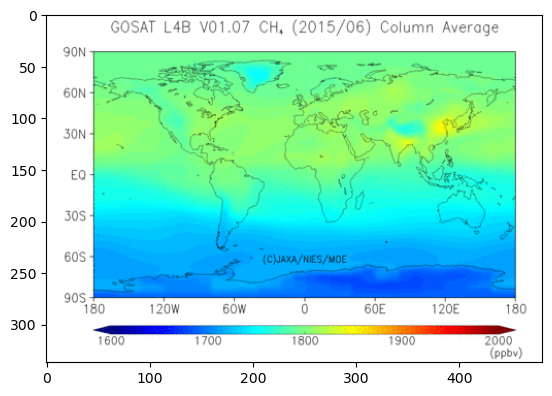

In [66]:
# from image
import matplotlib.pyplot as plt
image_methane = plt.imread(current_dir + r'\GoSAT_Methane\images\2015_06.png')
plt.imshow(image_methane)

In [123]:
# data from: https://www.eorc.jaxa.jp/GOSAT/CO2_monitor/index_NIES_V0297.html, station = Alabama 1
# converted to excel using: https://apps.automeris.io/wpd/
methane_gosat_csv = pd.read_csv(current_dir + '\GoSAT_Methane\Alabama_Methane_Dataset.csv', header = None)
# add time missing from 2015-06
methane_gosat_csv.loc[0] = ['2015/06/01',1850]
methane_gosat_csv.loc[1] = ['2016/06/01',1850]

methane_gosat_csv[['year','month','day']] = methane_gosat_csv[0].str.split('/', expand = True)
methane_gosat_csv = methane_gosat_csv[methane_gosat_csv['year'].astype(int) >= 2015]
methane_gosat_csv = methane_gosat_csv[methane_gosat_csv['year'].astype(int) < 2022]

methane_gosat_csv['date'] = methane_gosat_csv['year'].apply(lambda x: int(x)*10000) + methane_gosat_csv['month'].apply(lambda x: int(x)*100) + methane_gosat_csv['day'].apply(lambda x: int(x))
methane_gosat_csv = methane_gosat_csv.drop(columns = [0,'year','month','day'])
methane_gosat_csv = methane_gosat_csv.drop_duplicates(subset = 'date')
methane_gosat_csv = methane_gosat_csv.rename(columns = {1:'Methane_ppbv'})
methane_gosat_csv.head()

,Methane_ppbv,date
0,1850.000000,20150601
1,1850.000000,20160601
2,1868.106399,20170625
5,1868.106399,20170628
7,1868.396991,20170701


# Combining all together

In [124]:
# new_orleansdata, hurricane
combined_dataset = pd.merge(pd.merge(Air_Pressure2,Air_Temperature,how = 'outer',on=['coordinates','date']),Chlorophyll,how = 'outer',on=['coordinates','date'])
combined_dataset = pd.merge(pd.merge(combined_dataset,Humidity,how = 'outer',on=['coordinates','date']),Oxygen,how = 'outer',on=['coordinates','date'])
combined_dataset = pd.merge(combined_dataset,Salinity,how = 'outer',on=['coordinates','date'])
print(len(combined_dataset))
# combining if column rows appear twice
combined_dataset = pd.merge(combined_dataset,hurricanedata,how = 'outer', on=['coordinates','date'])
print(len(combined_dataset))

combined_dataset = pd.merge(combined_dataset,CO2,how = 'outer',on=['coordinates','date'])
# combined_dataset = pd.merge(combined_dataset,Methane,how = 'outer',on=['coordinates','date'])
combined_dataset = pd.merge(combined_dataset,methane_gosat_csv,how = 'outer',on=['date'])

combined_dataset['tropical_storm_occurence'] = combined_dataset['USA_SSHS']

# create 1 for each time a storm appears
combined_dataset['tropical_storm_occurence'] = combined_dataset['tropical_storm_occurence'].fillna(-999)
combined_dataset['tropical_storm_occurence'] = combined_dataset['tropical_storm_occurence'] + 100
combined_dataset['tropical_storm_occurence'] = combined_dataset['tropical_storm_occurence'].clip(lower=0)
combined_dataset['tropical_storm_occurence'][combined_dataset['tropical_storm_occurence'] != 0] = 1

# print(len(combined_dataset))

combined_dataset.head()

26563
26579


C:\Users\jkuhn\AppData\Local\Temp\ipykernel_1520\1816225623.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_dataset['tropical_storm_occurence'][combined_dataset['tropical_storm_occurence'] != 0] = 1


,air_pressure(mBar),date,coordinates,air_temperature,mass_concentration_of_chlorophyll_in_sea_water,relative_humidity,mass_concentration_of_oxygen_in_sea_wate,sea_water_practical_salinity,USA_SSHS,xco2,Methane_ppbv,tropical_storm_occurence
0,9999.00,20150601,29.0-92.0,28.9,NaN,NaN,NaN,NaN,NaN,NaN,1850.0,0.0
1,1015.20,20150601,28.0-92.0,28.9,NaN,NaN,NaN,NaN,NaN,NaN,1850.0,0.0
2,1015.90,20150601,29.0-88.0,26.7,NaN,NaN,NaN,NaN,NaN,NaN,1850.0,0.0
3,1015.98,20150601,28.0-94.0,11.0,NaN,49.9,NaN,35.24,NaN,NaN,1850.0,0.0
4,1015.70,20150601,30.0-87.0,25.8,NaN,NaN,NaN,NaN,NaN,NaN,1850.0,0.0


In [125]:
combined_dataset[['Methane_ppbv','date']]

,Methane_ppbv,date
0,1850.000000,20150601
1,1850.000000,20150601
2,1850.000000,20150601
3,1850.000000,20150601
4,1850.000000,20150601
...,...,...
29256,1898.037368,20211221
29257,1897.310888,20211223
29258,1898.327960,20211224
29259,1898.327960,20211227


In [126]:
combined_dataset.to_csv("dataset_combined.csv")  # saving to csv

In [100]:
len(combined_dataset.columns)

12